#### **CHEST X-RAY Classification Model**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import os 
import cv2

2025-10-26 14:34:21.158508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761489261.181015     877 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761489261.188015     877 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
INPUT_DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray'
SPLITS = ["train", "val", "test"]

image_paths = []
labels = []
splits = []

for split in SPLITS:
    split_path = os.path.join(INPUT_DIR, split)
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_path = os.path.join(split_path, class_name)
        if os.path.exists(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(class_path, file))
                    labels.append(class_name)
                    splits.append(split)

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels,
    'split': splits
})

print(f"Total images: {len(df)}")

print("Dataset Shape: ",df.shape) 

print("Distribution of Dataset: ",df.groupby('split')['label'].value_counts())

Total images: 5856
Dataset Shape:  (5856, 3)
Distribution of Dataset:  split  label    
test   PNEUMONIA     390
       NORMAL        234
train  PNEUMONIA    3875
       NORMAL       1341
val    NORMAL          8
       PNEUMONIA       8
Name: count, dtype: int64


In [4]:
# CHecking Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  5856 non-null   object
 1   label       5856 non-null   object
 2   split       5856 non-null   object
dtypes: object(3)
memory usage: 137.4+ KB


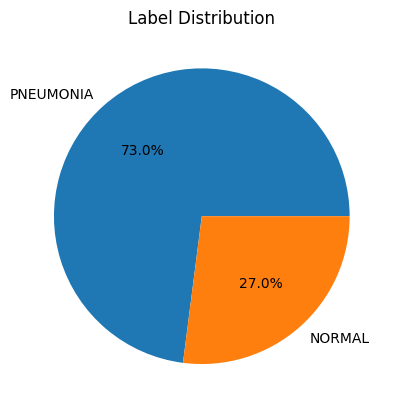

In [5]:
# Plot pie chart
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Label Distribution')
plt.ylabel('')
plt.show()

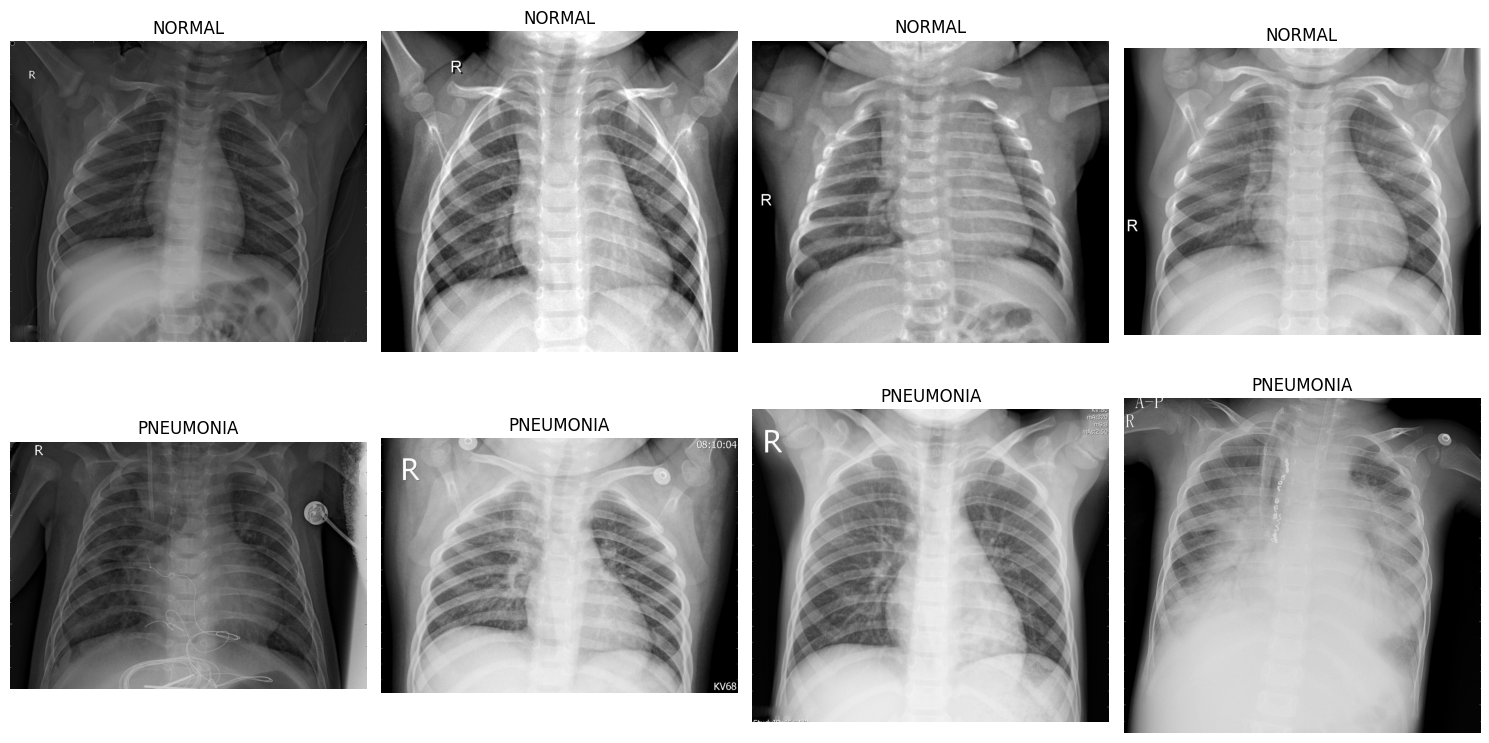

Image shape: (1336, 1256)
Image mode: L


In [6]:
from PIL import Image
# Display images from different classes
fig, axes = plt.subplots(2, 4, figsize=(15, 8))

# Show 4 normal images
normal_images = df[df['label'] == 'NORMAL']['image_path'].head(4)
for i, img_path in enumerate(normal_images):
    img = Image.open(img_path)
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title('NORMAL')
    axes[0, i].axis('off')

# Show 4 pneumonia images
pneumonia_images = df[df['label'] == 'PNEUMONIA']['image_path'].head(4)
for i, img_path in enumerate(pneumonia_images):
    img = Image.open(img_path)
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title('PNEUMONIA')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# Print image info
print("Image shape:", img.size)
print("Image mode:", img.mode)

In [7]:
# Data Preprocessing

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [8]:
# Model Building


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Model Building
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761489266.542079     877 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761489266.542792     877 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=15,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1761489271.109091     945 service.cc:148] XLA service 0x78b15800c1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761489271.109127     945 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761489271.109132     945 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761489271.398996     945 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/130 ━━━━━━━━━━━━━━━━━━━━ 14:22 7s/step - accuracy: 0.5625 - loss: 0.6874

I0000 00:00:1761489274.746039     945 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 52s 350ms/step - accuracy: 0.8064 - loss: 0.4504 - val_accuracy: 0.9082 - val_loss: 0.2271
Epoch 2/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9062 - loss: 0.1501

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.9062 - loss: 0.1501 - val_accuracy: 0.9102 - val_loss: 0.2224
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 324ms/step - accuracy: 0.9432 - loss: 0.1464 - val_accuracy: 0.9531 - val_loss: 0.1251
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9375 - loss: 0.1249 - val_accuracy: 0.9512 - val_loss: 0.1218
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 320ms/step - accuracy: 0.9707 - loss: 0.0848 - val_accuracy: 0.9541 - val_loss: 0.1217
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9375 - loss: 0.1509 - val_accuracy: 0.9551 - val_loss: 0.1241
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 323ms/step - accuracy: 0.9682 - loss: 0.0855 - val_accuracy: 0.9473 - val_loss: 0.1476
Epoch 8/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.9463 - val_loss: 0.1508
Epoch 9/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 321ms/step - accuracy: 0.9713 - loss: 0.0697 - val_accurac

In [11]:
# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)

Found 624 images belonging to 2 classes.


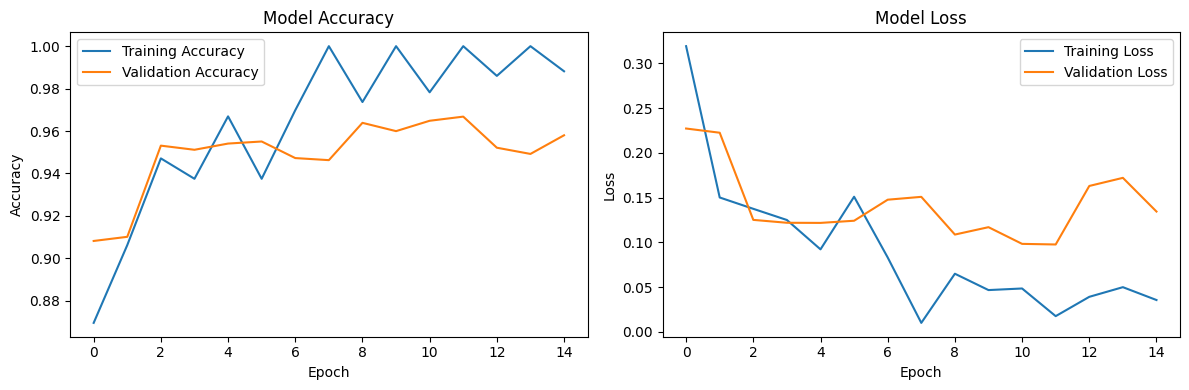

In [12]:
# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Make predictions on test set
predictions = model.predict(test_data)
predicted_classes = (predictions > 0.5).astype("int32")

# Get true labels
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

print("First 10 predictions:")
for i in range(10):
    print(f"True: {class_labels[true_classes[i]]}, Predicted: {class_labels[predicted_classes[i][0]]}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step
First 10 predictions:
True: NORMAL, Predicted: PNEUMONIA
True: NORMAL, Predicted: PNEUMONIA
True: NORMAL, Predicted: PNEUMONIA
True: NORMAL, Predicted: PNEUMONIA
True: NORMAL, Predicted: NORMAL
True: NORMAL, Predicted: NORMAL
True: NORMAL, Predicted: NORMAL
True: NORMAL, Predicted: PNEUMONIA
True: NORMAL, Predicted: PNEUMONIA
True: NORMAL, Predicted: PNEUMONIA


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.35      0.51       234
   PNEUMONIA       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624

Confusion Matrix:


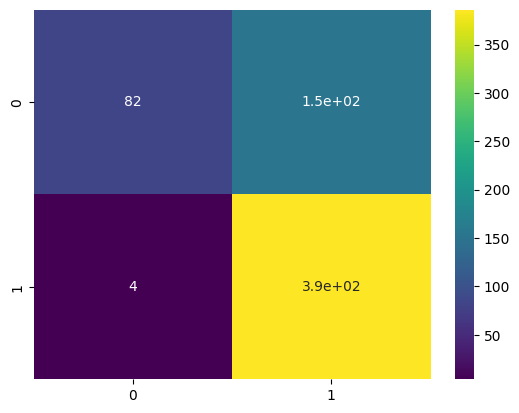

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, 
                          target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")

import seaborn as sns 

sns.heatmap(cm,annot = True,cmap = 'viridis')
plt.show()